In [207]:

#%matplotlib inline 

###########
#PDF PROCESSING FOR various INPUT 
# DEPENDING ON THE PDF_PROCESSING CLASS
#by Carl Schleussner, Climate Analytics
#carl.schleussner@climateanalytics.org
###########
# IMPORT AND CONFIG 
import numpy as np
import netCDF4 as net
import dimarray as da 
import sys
sys.path.append("./src/")
import itertools
import glob
import datetime
import pickle
import os
import pandas as pd
import matplotlib.pylab as plt 
from netCDF4 import Dataset,netcdftime,num2date

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8,6

os.chdir('/Users/peterpfleiderer/Documents/Projects/0p5_observed/pdf_processing-srex/')
try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")

###########
# Settings
###########

# PDF Method (currently defined: hist, python_silverman)
pdf_method='python_silverman'

# Set range for years for bootstrap sampling 
bs_range=[1958,2010]

# Variablelist
varinlist=[
    'TXX',
    'TNN',
    'WSDI',
    'Rx5day',
    'Rx1day'
          ] 

ref_period=[1960,1979]
target_periods=[[1991,2010],ref_period]
period_names=['Recent','ref']

timeaxis=np.arange(1958,2011)

# Input datasets
datasets=['HadEx2','GHCND','ERA','20CR','ERA_regrid','20CR_regrid']

# Set plottint colours
colordict={
    datasets[0]:"#247a9c",
    datasets[1]:"#df1a20",
    datasets[2]:"#49bc2f",
    datasets[3]:"#66087c",
    datasets[4]:"#9dbd1d",
    datasets[5]:"#c268d8"}


varoutdict={
    datasets[0]:{},    
    datasets[1]:{},    
    datasets[2]:{},    
    datasets[3]:{},    
    datasets[4]:{},    
    datasets[5]:{}}


In [208]:
##############
# HadEx2 & GHCND
##############

for varin in varinlist:
    for dataset in ['HadEx2','GHCND']:
        print varin,dataset
        if dataset =='HadEx2':
            read_in_data=da.read_nc('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/HadEx2/H2_'+varin+'_1901-2010_RegularGrid_global_3.75x2.5deg_LSmask.nc')['Ann']
        elif dataset =='GHCND':
            read_in_data=da.read_nc('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/GHCND/GHCND_'+varin+'_1951-2016_RegularGrid_global_2.5x2.5deg_LSmask.nc')['Ann']
            # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
        input_data=da.DimArray(read_in_data[19580101:20100101,:,:], axes=[timeaxis, read_in_data.lat, read_in_data.lon],dims=['year', 'lat', 'lon'] )
        
        # Mask for data availability (individual for each dataset)
        varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
        varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods)


TXX HadEx2
No of non-NAN grid cells in Mask over Ref period:  1095
No of non-NAN grid cells in Mask over Ref period and target period  [1991, 2010]  :  831
No of non-NAN grid cells in Mask over Ref period and target period  [1960, 1979]  :  831
no landmask used
TXX GHCND
No of non-NAN grid cells in Mask over Ref period:  1488
No of non-NAN grid cells in Mask over Ref period and target period  [1991, 2010]  :  1296
No of non-NAN grid cells in Mask over Ref period and target period  [1960, 1979]  :  1296
no landmask used
TNN HadEx2
No of non-NAN grid cells in Mask over Ref period:  1326
No of non-NAN grid cells in Mask over Ref period and target period  [1991, 2010]  :  1082
No of non-NAN grid cells in Mask over Ref period and target period  [1960, 1979]  :  1082
no landmask used
TNN GHCND
No of non-NAN grid cells in Mask over Ref period:  1781
No of non-NAN grid cells in Mask over Ref period and target period  [1991, 2010]  :  1631
No of non-NAN grid cells in Mask over Ref period and ta

In [209]:
##############################
# 20CR
###############
dataset='20CR'
for varin in ['TXX']:    
    print varin.lower()
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/*/'+varin.lower()+'*2014.nc')[0]
    nc_in=Dataset(in_file,"r")
    print varin,in_file
    # handle time information
    try:
        time=nc_in.variables['time'][:]
        datevar = []
        # if no specification
        time_unit=nc_in.variables['time'].units
        try:	
            cal_temps = nc_in.variables['time'].calendar
            datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
        except:
            datevar.append(num2date(time,units = time_unit))
        year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])
    except: pass

    lat=nc_in.variables['lat'][:]
    lon=nc_in.variables['lon'][:]

    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1958) & (year<2010))[0]
    var_in=nc_in.variables['air'][:,:,:]
    if var_in.mean()>150:var_in-=273.15
    
    input_data=da.DimArray(var_in[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )

    # Mask for data availability (individual for each dataset)
    varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
    varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=True)

    # Mask Antarctica and renormalize
    new_mask=varoutdict[dataset][varin]._masks['global'].copy()
    below_60S=np.where(lat<=-60)[0]
    new_mask.ix[below_60S,:]=np.nan
    new_mask/=float(np.sum(new_mask[np.isfinite(new_mask)])) 
    varoutdict[dataset][varin]._masks['global']=new_mask.copy()

txx
TXX /Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/20CR (peter.pfleiderer@climateanalytics.org)/txx.20CR.1851-2014.nc
No of non-NAN grid cells in Reference Mask:  18048
no landmask used


In [210]:
##############################
# 20CR_regrid
###############
dataset='20CR_regrid'
for varin in ['TXX']:    
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/*/'+varin.lower()+'*regrid*')[0]
    nc_in=Dataset(in_file,"r")
    print varin,in_file
    # handle time information
    try:
        time=nc_in.variables['time'][:]
        datevar = []
        # if no specification
        time_unit=nc_in.variables['time'].units
        try:	
            cal_temps = nc_in.variables['time'].calendar
            datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
        except:
            datevar.append(num2date(time,units = time_unit))
        year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])
    except: pass

    lat=nc_in.variables['lat'][:]
    lon=nc_in.variables['lon'][:]

    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1958) & (year<2010))[0]
    var_in=nc_in.variables['air'][:,:,:]
    if var_in.mean()>150:var_in-=273.15
    
    input_data=da.DimArray(var_in[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )

    # Mask for data availability (individual for each dataset)
    varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
    varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=True)

    # Mask Antarctica and renormalize
    new_mask=varoutdict[dataset][varin]._masks['global'].copy()
    below_60S=np.where(lat<=-60)[0]
    new_mask.ix[below_60S,:]=np.nan
    new_mask/=float(np.sum(new_mask[np.isfinite(new_mask)])) 
    varoutdict[dataset][varin]._masks['global']=new_mask.copy()

TXX /Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/20CR (peter.pfleiderer@climateanalytics.org)/txx.20CR.1851-2014_regrid_3.75x2.5deg.nc
No of non-NAN grid cells in Reference Mask:  7008
no landmask used


In [211]:
##############
# ERA40 - ERAinterim
##############
dataset='ERA'
for varin in ['TXX']:    
    # ERA40
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/ERA40/'+varin.lower()+'*2002.nc')[0]
    nc_in=Dataset(in_file,"r")
    print varin,in_file
    # handle time information
    time=nc_in.variables['time'][:]
    datevar = []
    # if no specification
    time_unit=nc_in.variables['time'].units
    try:
        cal_temps = nc_in.variables['time'].calendar
        datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
    except:
        datevar.append(num2date(time,units = time_unit))
    year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])
    
    lat=nc_in.variables['latitude'][:]
    lon=nc_in.variables['longitude'][:]
    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1958) & (year<1979))[0]
    ERA40=nc_in.variables['t2m'][:,:,:]
    if ERA40.mean()>150:ERA40-=273.15

    ERA40=da.DimArray(ERA40[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )


    # ERAinterim
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/ERAinterim/'+varin.lower()+'*2016.nc')[0]
    nc_in=Dataset(in_file,"r")
    # handle time information
    time=nc_in.variables['time'][:]
    datevar = []
    # if no specification
    time_unit=nc_in.variables['time'].units
    try:
        cal_temps = nc_in.variables['time'].calendar
        datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
    except:
        datevar.append(num2date(time,units = time_unit))
    year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])

    lat=nc_in.variables['latitude'][:]
    lon=nc_in.variables['longitude'][:]
    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1979) & (year<2010))[0]
    ERAinterim=nc_in.variables['t2m'][:,:,:]
    if ERAinterim.mean()>150:ERAinterim-=273.15

    ERAinterim=da.DimArray(ERAinterim[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )

    input_data=da.concatenate((ERA40.copy(), ERAinterim.copy()), axis='year')
    
    # Mask for data availability (individual for each dataset)
    varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
    varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=True)

    # Mask Antarctica and renormalize
    new_mask=varoutdict[dataset][varin]._masks['global'].copy()
    below_60S=np.where(lat<=-60)[0]
    new_mask.ix[below_60S,:]=np.nan
    new_mask/=float(np.sum(new_mask[np.isfinite(new_mask)])) 
    varoutdict[dataset][varin]._masks['global']=new_mask.copy()


TXX /Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/ERA40/txx_era40.1958-2002.nc
No of non-NAN grid cells in Reference Mask:  65160
no landmask used


In [212]:
##############
# ERA40 - ERAinterim _regrid
############## 
dataset='ERA_regrid'
for varin in ['TXX']:    
    # ERA40
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/ERA40/'+varin.lower()+'*regrid*')[0]
    nc_in=Dataset(in_file,"r")
    print varin,in_file
    # handle time information
    time=nc_in.variables['time'][:]
    datevar = []
    # if no specification
    time_unit=nc_in.variables['time'].units
    try:
        cal_temps = nc_in.variables['time'].calendar
        datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
    except:
        datevar.append(num2date(time,units = time_unit))
    year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])
    
    lat=nc_in.variables['lat'][:]
    lon=nc_in.variables['lon'][:]
    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1958) & (year<1979))[0]
    ERA40=nc_in.variables['t2m'][:,:,:]
    if ERA40.mean()>150:ERA40-=273.15
        
    ERA40=da.DimArray(ERA40[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )


    # ERAinterim
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/ERAinterim/'+varin.lower()+'*regrid*')[0]
    nc_in=Dataset(in_file,"r")
    # handle time information
    time=nc_in.variables['time'][:]
    datevar = []
    # if no specification
    time_unit=nc_in.variables['time'].units
    try:
        cal_temps = nc_in.variables['time'].calendar
        datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
    except:
        datevar.append(num2date(time,units = time_unit))
    year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])

    lat=nc_in.variables['lat'][:]
    lon=nc_in.variables['lon'][:]
    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1979) & (year<2010))[0]
    ERAinterim=nc_in.variables['t2m'][:,:,:]
    if ERAinterim.mean()>150:ERAinterim-=273.15

    ERAinterim=da.DimArray(ERAinterim[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )

    input_data=da.concatenate((ERA40, ERAinterim), axis='year')

    # Mask for data availability (individual for each dataset)
    varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
    varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=True)
    
    # Mask Antarctica and renormalize
    new_mask=varoutdict[dataset][varin]._masks['global'].copy()
    below_60S=np.where(lat<=-60)[0]
    new_mask.ix[below_60S,:]=np.nan
    new_mask/=float(np.sum(new_mask[np.isfinite(new_mask)])) 
    varoutdict[dataset][varin]._masks['global']=new_mask.copy()


TXX /Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/ERA40/txx_era40.1958-2002_regrid_3.75x2.5deg.nc
No of non-NAN grid cells in Reference Mask:  7008
no landmask used


In [213]:
for varin in varinlist:
    for dataset in datasets:
        try:
            print dataset,varin   
            # use bins from Hadex2 for all datasets - important for eye-inspection
            # use bin_range= 
            if dataset=='HadEx2':bin_range=None
            if dataset!='HadEx2':bin_range=varoutdict['HadEx2'][varin]._histogram_range
                
            # relative diff for precipitation indices
            if varin in ['RX5day','RX1day']:relative_diff=True
            if varin not in ['RX5day','RX1day']:relative_diff=False
            print "relative_diff=",relative_diff
            
            varoutdict[dataset][varin].derive_time_slices(ref_period,target_periods,period_names)
            varoutdict[dataset][varin].derive_distributions()
            
            varoutdict[dataset][varin].derive_pdf_difference('ref','Recent',pdf_method=pdf_method,bin_range=bin_range,relative_diff=relative_diff)

            # Get bootstrapping confidence intervals
            varoutdict[dataset][varin].bootstrapping(bs_range,10)   
            varoutdict[dataset][varin].derive_bootstrapped_conf_interval(pdf_method=pdf_method,relative_diff=relative_diff)
        except: pass

HadEx2 TXX
Recent [1991, 2010]
ref [1960, 1979]
relative_diff= False
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: -96
GHCND TXX
Recent [1991, 2010]
ref [1960, 1979]
relative_diff= False
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: -60
ERA TXX
Recent [1991, 2010]
ref [1960, 1979]
relative_diff= False
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
20CR TXX
Recent [1991, 2010]
ref [1960, 1979]
relative_diff= False
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
ERA_regrid TXX
Recent [1991, 2010]
ref [1960, 1979]
relative_diff= False
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap k

In [214]:
###########
# Plot Main
###########
f,pl=plt.subplots(nrows=2,ncols=3,figsize=(10,6))
pplot=pl.flatten()

region='global'
distro='pdf'

unit_dict={
    'TXX':'Deg C',
    'TNN':'Deg C',
    'WSDI':'days',
    'Rx5day':'$\%$',
    'Rx1day':'$\%$'
          }

from matplotlib import rc
rc('text', usetex=True)

for varin,k in zip(varinlist,range(len(pplot))):
    
    #for dataset in varoutdict.keys():
    for dataset in ['HadEx2','GHCND','ERA','20CR']:

#         pplot[k].plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
#                  varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][50],color='grey')
        try:
            pl5=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][5]#/varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][50].max()
            pl95=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][95]#/varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][50].max()
            pplot[k].fill_between(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                            pl95,pl5,color=colordict[dataset],
                                  alpha=0.4),#label='90% ref period')

            pplot[k].plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                     varoutdict[dataset][varin]._distributions[region][distro]['Recent_ref'],label=dataset,color=colordict[dataset])

            pplot[k].set_title(varin)
            pplot[k].set_xlabel(unit_dict[varin])
        except: pass

pplot[5].axis('off')
for dataset in ['HadEx2','GHCND','ERA','20CR']:pplot[5].plot(1,1,label=dataset,color=colordict[dataset])
pplot[5].legend(loc='upper right')

plt.tight_layout()

# f.suptitle('Observed 0.5 degree difference for HadEX2')
# pplot[1].text(-100, 0.08,'Observed 0.5 degree difference for '+region+' HadEX2 GMT: '+gmtds, fontsize=16,color='grey')
plt.savefig('../plots/Observed_0p5_degree_difference_all_DS_'+pdf_method+'.pdf')
plt.clf()

In [215]:
############
# Plot Diff Maps
############
plt.clf()
for varin in varinlist:
    for dataset in datasets:
        try:
            tmp=varoutdict[dataset][varin]
            mask=tmp._masks['global']
            mask[np.isfinite(mask)]=1
            diff=np.array(tmp._data_sliced['Recent'])*mask-np.array(tmp._data_sliced['ref'])*mask
            varoutdict[dataset][varin].plot_map(to_plot=diff,color_range=[-1.2,1.2],color_palette=plt.cm.PiYG,color_label=varin,out_file='../plots/diff_'+varin+'_'+dataset.replace('_',' ')+'.png')
        except: pass
        

In [ ]:
###########
# Plot Masks
###########
for dataset in datasets:
    print dataset
    maa=varoutdict[dataset]['TXX']._masks['global']
    print len(np.where(np.isfinite(maa))[0])
    print len(np.where(np.isfinite(maa)==False)[0])
    varoutdict[dataset]['TXX'].plot_map(varoutdict[dataset]['TXX']._masks['global'],title=dataset.replace('_',' '),color_label='ratio of area',show=False,out_file='../plots/'+dataset+'_mask_global.png')


In [216]:
################
# with HadEx2 mask for ERA and 20CR
################

for varin in ['TXX']:
    for dataset in ['ERA_regrid','20CR_regrid']:
        print dataset
        
        # use HadEx2 mask
        varoutdict[dataset][varin]._masks['global']=varoutdict['HadEx2'][varin]._masks['global']
        # use HadEx2 bin_range
        bin_range=varoutdict['HadEx2'][varin]._histogram_range
        
        # Derive time slices
        varoutdict[dataset][varin].derive_time_slices(ref_period,target_periods,period_names)
        varoutdict[dataset][varin].derive_distributions()

        varoutdict[dataset][varin].derive_pdf_difference('ref','Recent',pdf_method=pdf_method,bin_range=bin_range)

        # Get bootstrapping confidence intervals
        varoutdict[dataset][varin].bootstrapping(bs_range,10)   
        varoutdict[dataset][varin].derive_bootstrapped_conf_interval(pdf_method=pdf_method)

ERA_regrid
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
20CR_regrid
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0


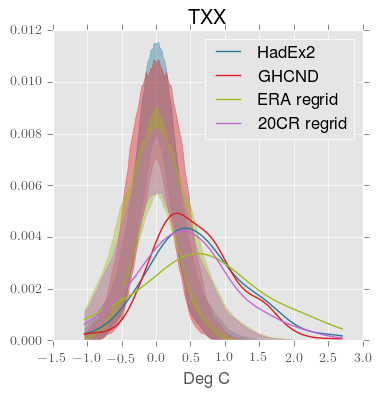

In [222]:
###########
# PLOTS with reanalysis masked for HadEx2 coverage
###########
f,pl=plt.subplots(nrows=1,figsize=(4,4))

region='global'
distro='pdf'

unit_dict={
    'TXX':'Deg C',
    'TNN':'Deg C',
    'WSDI':'days',
    'Rx5day':'$\%$',
    'Rx1day':'$\%$'
          }

from matplotlib import rc
rc('text', usetex=True)

    
for dataset in ['HadEx2','GHCND','ERA_regrid','20CR_regrid']:

    pl5=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][5]#/varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][50].max()
    pl95=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][95]#/varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][50].max()
    pl.fill_between(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                        pl95,pl5,color=colordict[dataset],
                              alpha=0.4),#label='90% ref period')
    
    pl.plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                 varoutdict[dataset][varin]._distributions[region][distro]['Recent_ref'],label=dataset.replace('_',' '),color=colordict[dataset])

    pl.legend(loc='upper right')
    pl.set_xlabel(unit_dict[varin])
    pl.set_title(varin)


# f.suptitle('Observed 0.5 degree difference (Reanalysis with HadEX2 coverage mask)')
# pplot[1].text(-100, 0.08,'Observed 0.5 degree difference for '+region+' HadEX2 GMT: '+gmtds, fontsize=16,color='grey')
plt.show()

In [220]:
###########
# PLOTS result
###########

f,pl=plt.subplots(nrows=1,ncols=2,figsize=(8,4))
pplot=pl.flatten()

region='global'
distro='pdf'

unit_dict={
    'txx':'Deg C',
    'tnn':'Deg C'
          }

from matplotlib import rc
rc('text', usetex=True)

for varin,k in zip(varinlist,range(len(pplot))):
    
    for dataset in ['HadEx2','GHCND','ERA','20CR']:

#         pplot[k].plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
#                  varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][50],color='grey')

        pl5=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][5]#/varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][50].max()
        pl95=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][95]#/varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][50].max()
        pplot[k].fill_between(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                        pl95,pl5,color=colordict[dataset],
                              alpha=0.4),#label='90% ref period')

        pplot[k].plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                 varoutdict[dataset][varin]._distributions[region][distro]['Recent_ref'],label=dataset.replace('_',' '),color=colordict[dataset])

        pplot[k].legend(loc='best')
        pplot[k].set_xlabel(unit_dict[varin])
        pplot[k].set_title(varin)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

f.suptitle('Observed 0.5 degree difference')
# pplot[1].text(-100, 0.08,'Observed 0.5 degree difference for '+region+' HadEX2 GMT: '+gmtds, fontsize=16,color='grey')
plt.show()
plt.clf()

KeyError: 'TXX'

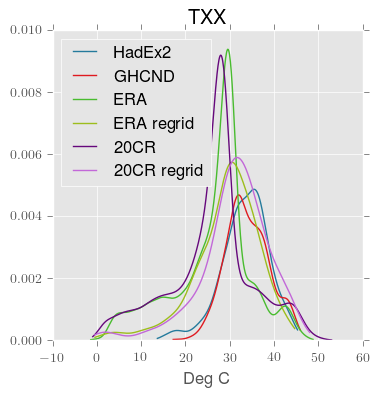

In [228]:
################
# influence of regridding to HadEx2 grid
################

f,pl=plt.subplots(nrows=1,ncols=1,figsize=(4,4))

varin='TXX'
for dataset in ['HadEx2','GHCND','ERA','ERA_regrid','20CR','20CR_regrid']:
    dat=varoutdict[dataset][varin]._distributions['global']['ref']
    bin_range=[dat.min(),dat.max()]
    output,no_nans=varoutdict[dataset][varin].kernel_density_estimation(dat,bin_range)
    pl.plot(output[:,0],output[:,1],color=colordict[dataset],label=dataset.replace('_',' '))
    pl.legend(loc='best')
    pl.set_xlabel(unit_dict[varin])
    pl.set_title(varin)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()
plt.clf()